# Thresholding and preprocessing


Fluorescence datasets ideally reflect a relationship between the pixels in an image and the location and local density of your fluorescent molecule in a sample. However, properties of the detectors, optics, or even the samples can confound direct interpretation of this data. Here we will present some operations that can mitigate these effects to achieve robust hypothesis testing.

Today, we will explore ways to automatically define the ROIs (regions of interest) and deal with aberrations in the data that can make such analysis difficult on raw data

Part 1: Load, understand and visualize the data  


Part 2: Thresholding
> a) Global threshold and masking     
b) Pixel intensity distributions   
c) Automatic threshold detection  

Part 3: Filtering and background subtraction
> a) Filtering out noise   
b) Background subtraction  
c) Combining preprocessing + thresholding  

***
# Part 1: Load, understand and visualize the data

First, let's import packages and set some plotting defaults


In [1]:
# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import skimage

sns.set_style('dark', rc={'image.cmap':'inferno'})

import matplotlib
matplotlib.rc('font', family='monospace', weight='bold', size=20)

### Part 1a) Load the images
First we'll set the data directory. Try printing the directory contents to make sure we've found the right path

In [2]:
# CHANGE PATH TO WHERE THE DATA IS ON YOUR COMPUTER
data_dir = "/Users/mhturner/Documents/GitHub/StanfordBIOS254-2019/Data/L2Data"
data_fn = 'HAC-Cit-KRAB+dox_s41_t60.tif'
import os
dir_contents = os.listdir(data_dir)
print(dir_contents)

['HAC-Cit-KRAB+dox_s41_t60.json', 'HAC-Cit-KRAB+dox_s41_t60.tif']


Now let's load the .tif image stack

In [3]:
from skimage.io import imread

raw_data = np.uint16(imread(os.path.join(data_dir, data_fn)))


Check the dimensions of the data

In [4]:
raw_data.shape

(512, 512, 3)

### Part 1b) Load the metadata

Load the metadata, which is in JSON format

In [5]:
import json
metadata_fn = 'HAC-Cit-KRAB+dox_s41_t60.json'
with open(os.path.join(data_dir, metadata_fn), mode='r') as metadata_file:
    metadata = json.load(metadata_file)

Take a look at the metadata dictionary

In [6]:
for key, value in metadata.items():
   print(key + ': ' + str(value))

axes: ['XYC']
channels: ['DIC', 'YFP', 'RFP']


Let's re-label the slices with names, instead of numbers.

In [7]:
data = {}
for idx, channel in enumerate(metadata['channels']):
    data[channel] = raw_data[:,:,idx]
    print(channel)

DIC
YFP
RFP


### Part 1c) Visualize the images

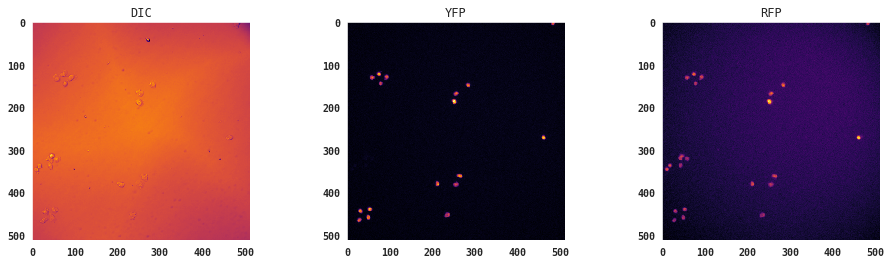

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for idx, channel in enumerate(metadata['channels']):
    ax[idx].imshow(data[channel])
    ax[idx].set_title(channel)


***
# Part 2: Thresholding and masking

Suppose we want to automatically select regions of interest (ROIs) from these images to, for example, count cells or measure the intensity of some fluorescent signal within the cells. One simple way to do this is by thresholding the image based on the pixel intensity.

To illustrate, we will focus on the YFP channel

In [9]:
from ipywidgets import interactive
channel = 'YFP'
data_range = data[channel].max() - data[channel].min()
@interactive
def show_masks(thresh=(data[channel].min(), data[channel].max(), data_range/6)): # thresh slider takes three inputs (min, max, step_size)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    mask = np.zeros(data[channel].shape)
    
    mask[data[channel] >=thresh] = 1
    
    ax[0].imshow(data[channel])
    ax[0].set_title('Image')

    ax[1].imshow(mask, vmin=0, vmax=1)
    ax[1].set_title('Mask')
show_masks

interactive(children=(FloatSlider(value=517.0, description='thresh', max=734.0, min=300.0, step=72.33333333333…

This is nice but the idea was to *automate* this process. How do we choose an appropriate threshold value without the need for user input? Luckily there exist several auotmatic threshold calculation methods that are included in the scikit-image library. Generally these automatic threshold methods rely on the distribution of pixel intensity values. Let's take a look at that distribution for our image.

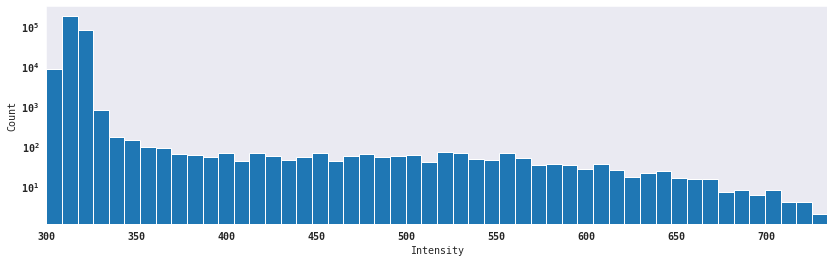

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.hist(data[channel].flatten(), bins=50) 
ax.set_xlabel('Intensity')
ax.set_ylabel('Count')
ax.set_xlim(data[channel].min(),data[channel].max())
ax.set_yscale('log')

Now let's use some built-in automatic threshold algorithms to define a threshold for our image

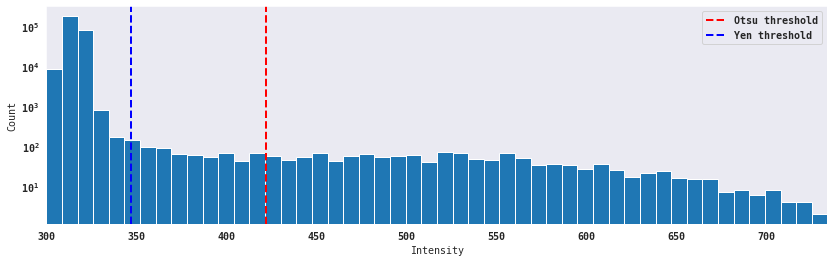

In [11]:
from skimage.filters import threshold_otsu, threshold_yen

thresh_otsu = threshold_otsu(data[channel])
thresh_yen = threshold_yen(data[channel]) 

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.hist(data[channel].flatten(), bins=50)
plt.axvline(thresh_otsu, ls='--', lw=2, c='r', label='Otsu threshold') 
plt.axvline(thresh_yen, ls='--', lw=2, c='b', label='Yen threshold') 
ax.legend()
ax.set_xlabel('Intensity')
ax.set_ylabel('Count')
ax.set_xlim(data[channel].min(),data[channel].max())
ax.set_yscale('log')

Now let's look at the masks generated using these automatic thresholds. First, since we will be doing this a lot, let's define our own function to calculate a mask given: 1) the original image and 2) a threshold value

In [12]:
def get_mask(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    return(mask)

Text(0.5, 1.0, 'Yen threshold')

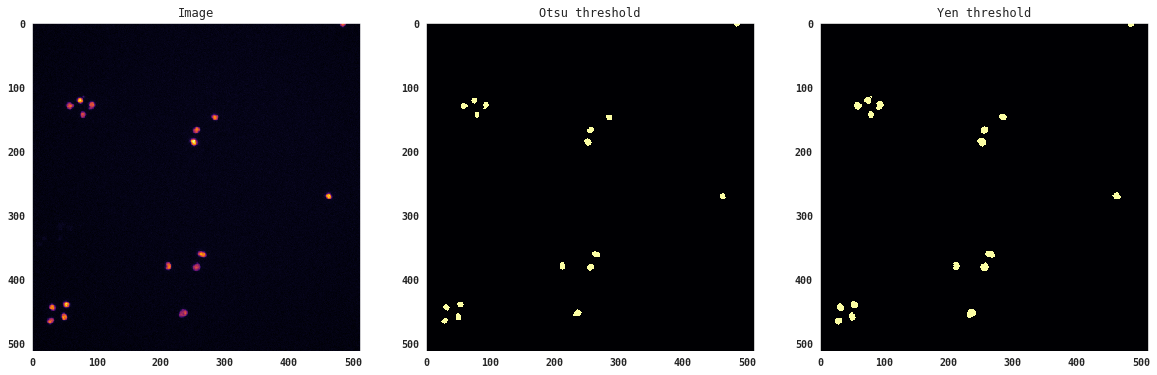

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

mask_otsu = get_mask(data[channel], thresh_otsu)
mask_yen = get_mask(data[channel], thresh_yen)

ax[0].imshow(data[channel])
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, vmin=0, vmax=1)
ax[1].set_title('Otsu threshold')

ax[2].imshow(mask_yen, vmin=0, vmax=1)
ax[2].set_title('Yen threshold')

***
# Part 3: Filtering and background subtraction

To illustrate the need for preprocessing, let's try to automatically threshold the other fluorescent channel of our data

Text(0.5, 1.0, 'Yen threshold')

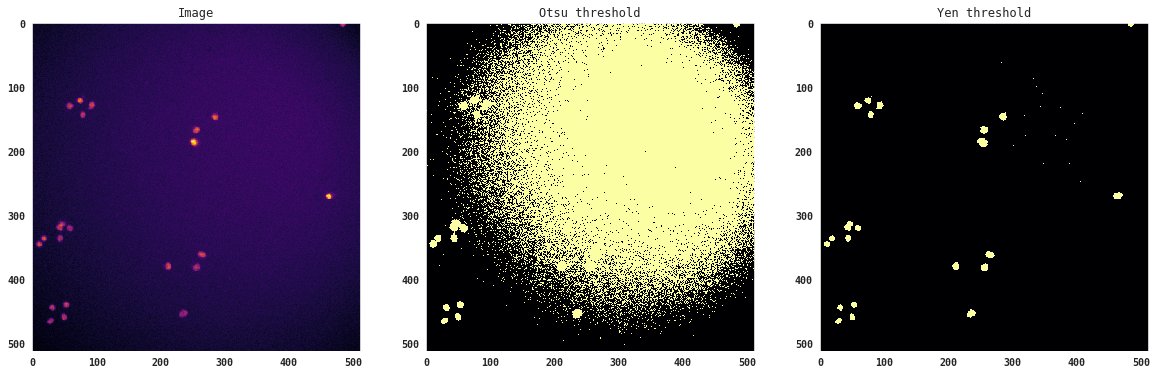

In [14]:
channel = 'RFP'

thresh_otsu = threshold_otsu(data[channel])
thresh_yen = threshold_yen(data[channel]) 

mask_otsu = get_mask(data[channel], thresh_otsu)
mask_yen = get_mask(data[channel], thresh_yen)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(data[channel])
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, vmin=0, vmax=1)
ax[1].set_title('Otsu threshold')

ax[2].imshow(mask_yen, vmin=0, vmax=1)
ax[2].set_title('Yen threshold')

Uh oh - our simple automatic thresholding fails for the other two channels. There are at least two reasons for these failures:  
1) Salt & pepper, speckly noise  
2) A background due to uneven illumination or other optical aberrations

We'll try to get rid of the salt and pepper noise first. We'll do that by __filtering__

We need to import packages and filters:

In [15]:
from skimage.filters.rank import mean as mean_filter
from skimage.filters.rank import minimum as min_filter
from skimage.filters.rank import maximum as max_filter
from skimage.filters.rank import median as median_filter
from skimage.morphology import disk

The filter types imported above (mean, min, max, median) describe the __computation__ done by the filter. We also need to describe the __size__ of the filter - i.e. what region of space to perform the computation over, for each pixel of the image.
First, let's examine the effect of filter sizes.  
  
A common way to specify the filter size is to use a __"structuring element"__, which is just a matrix of 0's and 1's telling the filtering operation which pixels in a local region to include in the computation. Let's look at a couple of structuring elements:

(5, 5)
(9, 9)
(17, 17)
(33, 33)


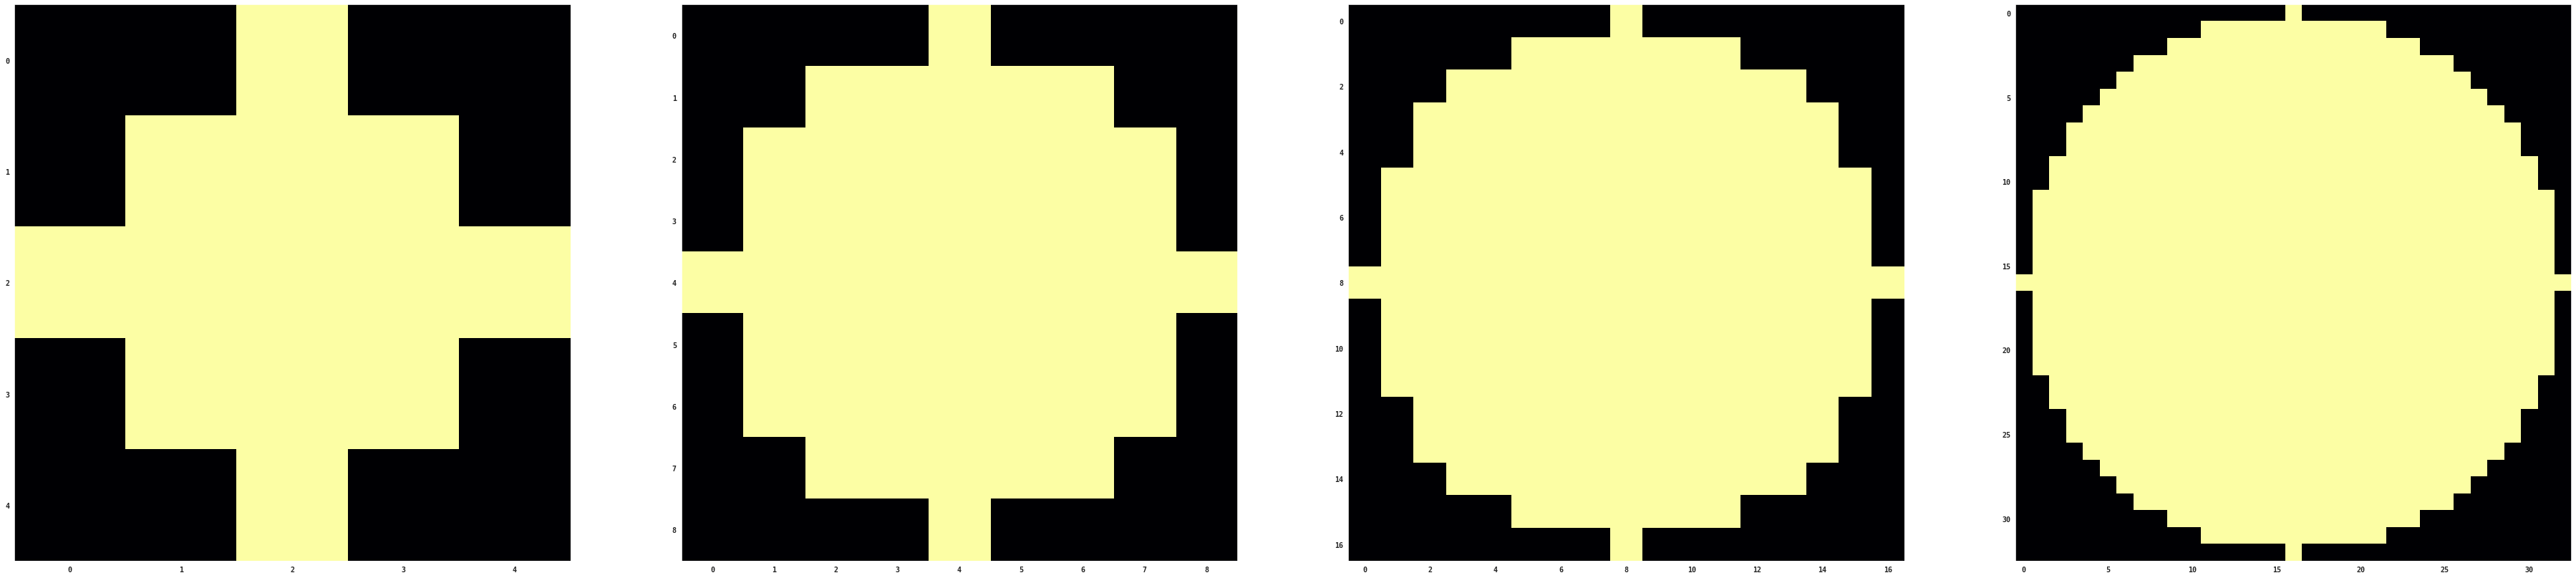

In [16]:
filter_sizes = [2, 4, 8, 16]
fig, ax = plt.subplots(1, 4, figsize=(64, 50))
for ind, f_radius in enumerate(filter_sizes):
    s_elem = disk(f_radius)
    ax[ind].imshow(s_elem)
    print(s_elem.shape)

Now let's try applying a filter with various sizes to the same test image:

Now, try using a median filter to remove the salt-pepper noise. Can you see differences in the images? Play with the filter size and see how that affects the filtering.

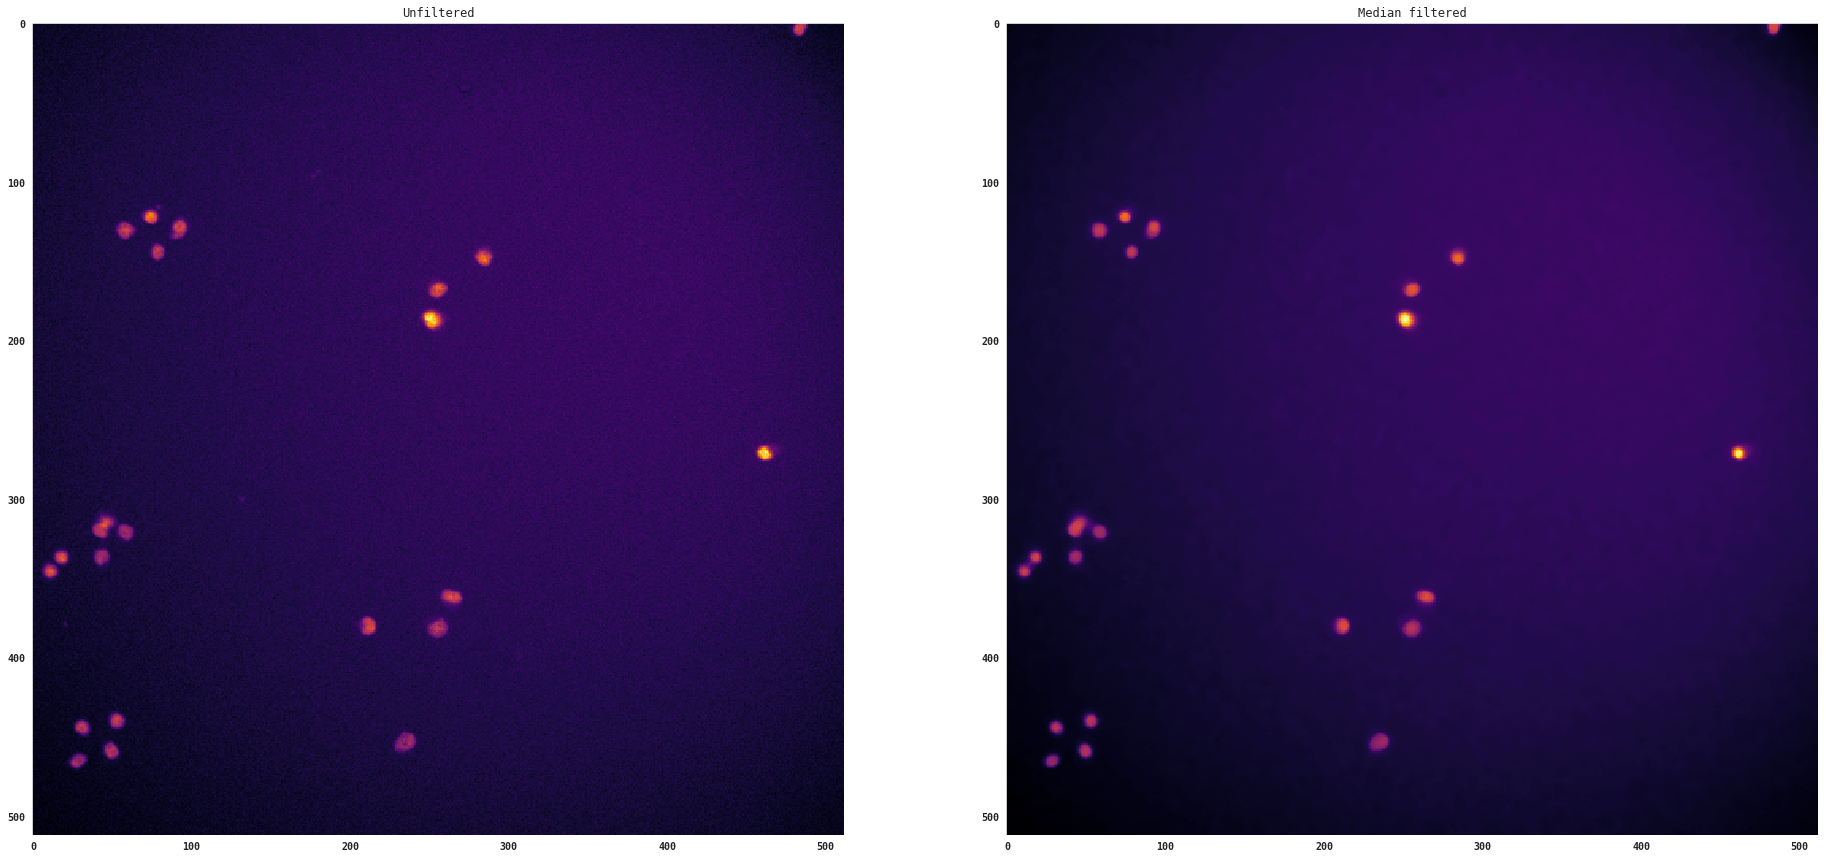

In [17]:
f_size = 4
data_filt = median_filter(data[channel], disk(f_size))

fig, ax = plt.subplots(1, 2, figsize=(32, 25))
ax[0].imshow(data[channel])
ax[0].set_title('Unfiltered')
ax[1].imshow(data_filt)
ax[1].set_title('Median filtered');

Now, we can take the filtered image and further pre-process. We'd like to remove the un-even illumination. First, we will extract the background. The radius should be set to at least the size of the largest object that is not part of the background.

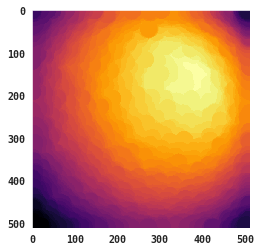

In [18]:
# the radius should be set to at least the size of the largest object that is not part of the background
r = 20
structuring_element = disk(r)
background = min_filter(data_filt, structuring_element)
plt.imshow(background, cmap='inferno', interpolation = 'none')#, vmin = 0, vmax = 3000)

Next, let's substract out the background from the dataset.

Text(0.5, 1.0, 'Filtered, background subtracted')

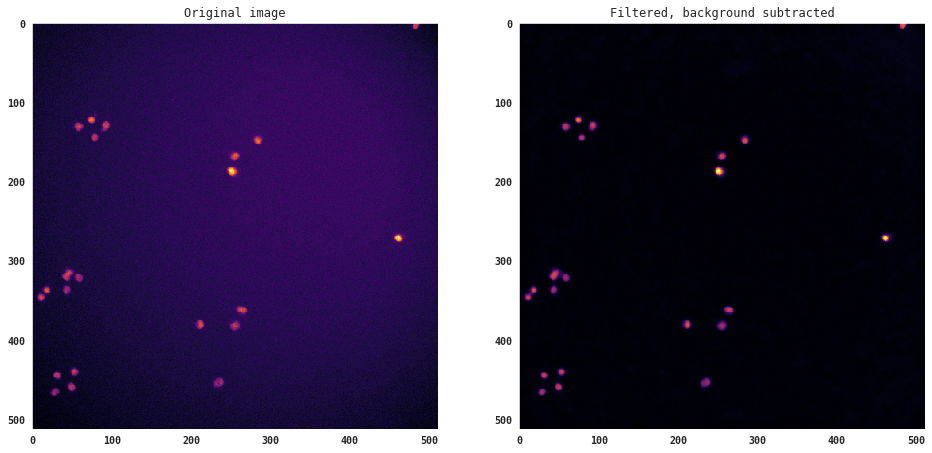

In [19]:
background_subtracted = data_filt - background
background_subtracted[background_subtracted<0] = 0

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(data[channel], interpolation = 'none')
ax[0].set_title('Original image')
ax[1].imshow(background_subtracted, interpolation = 'none')
ax[1].set_title('Filtered, background subtracted')

With our pre-processed dataset, let's try the thresholding again.

Text(0.5, 1.0, 'Yen threshold')

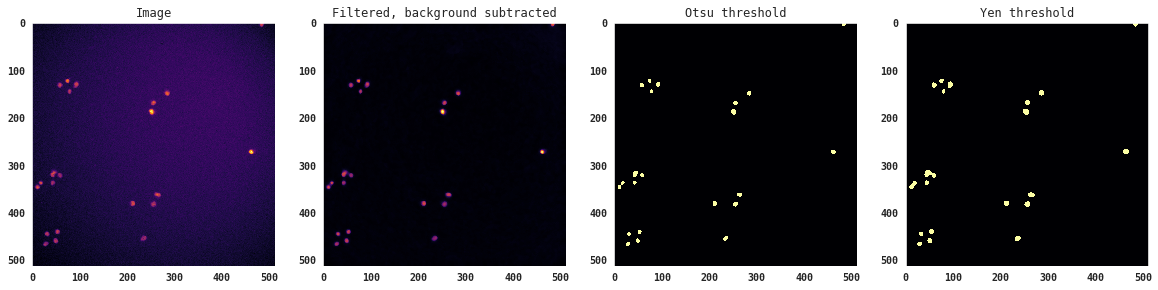

In [20]:
thresh_otsu = threshold_otsu(background_subtracted)
thresh_yen = threshold_yen(background_subtracted) 

mask_otsu = get_mask(background_subtracted, thresh_otsu)
mask_yen = get_mask(background_subtracted, thresh_yen)

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(data[channel])
ax[0].set_title('Image')

ax[1].imshow(background_subtracted)
ax[1].set_title('Filtered, background subtracted')

ax[2].imshow(mask_otsu, vmin=0, vmax=1)
ax[2].set_title('Otsu threshold')

ax[3].imshow(mask_yen, vmin=0, vmax=1)
ax[3].set_title('Yen threshold')

Text(0.5, 1.0, 'Yen threshold')

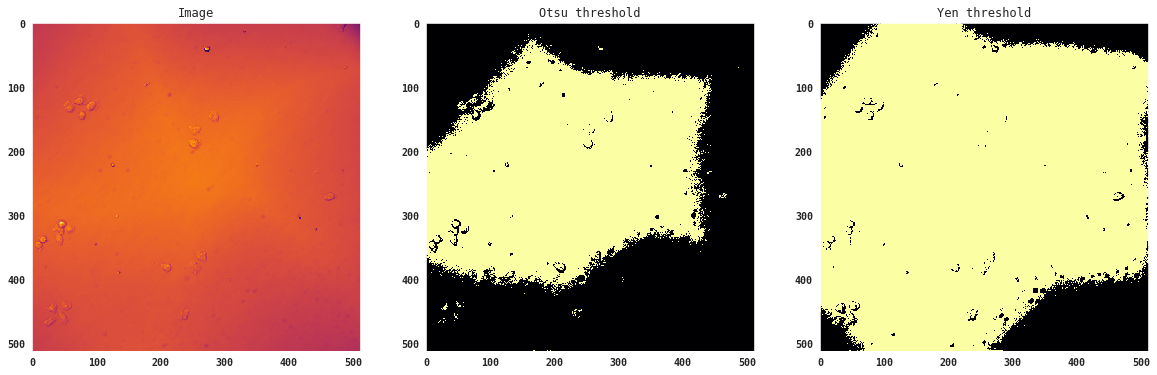

In [21]:
channel = 'DIC'

thresh_otsu = threshold_otsu(data[channel])
thresh_yen = threshold_yen(data[channel]) 

mask_otsu = get_mask(data[channel], thresh_otsu)
mask_yen = get_mask(data[channel], thresh_yen)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(data[channel])
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, vmin=0, vmax=1)
ax[1].set_title('Otsu threshold')

ax[2].imshow(mask_yen, vmin=0, vmax=1)
ax[2].set_title('Yen threshold')

Text(0.5, 1.0, 'Sobel filtered')

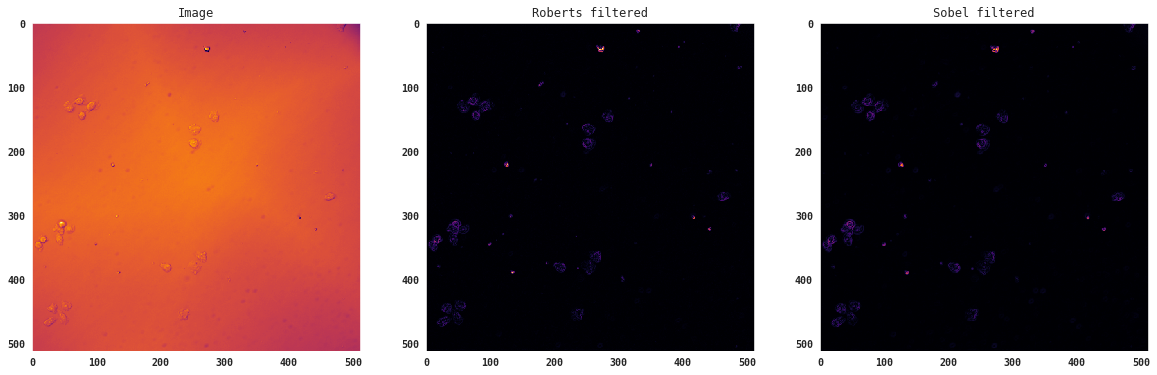

In [22]:
channel = 'DIC'
from skimage.filters import roberts, sobel
sigma = 3
data_roberts = roberts(data[channel])
data_sobel = sobel(data[channel])

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(data[channel], cmap='inferno')
ax[0].set_title('Image')

ax[1].imshow(data_roberts, cmap='inferno')
ax[1].set_title('Roberts filtered')

ax[2].imshow(data_sobel, cmap='inferno')
ax[2].set_title('Sobel filtered')




Text(0.5, 1.0, 'Yen threshold')

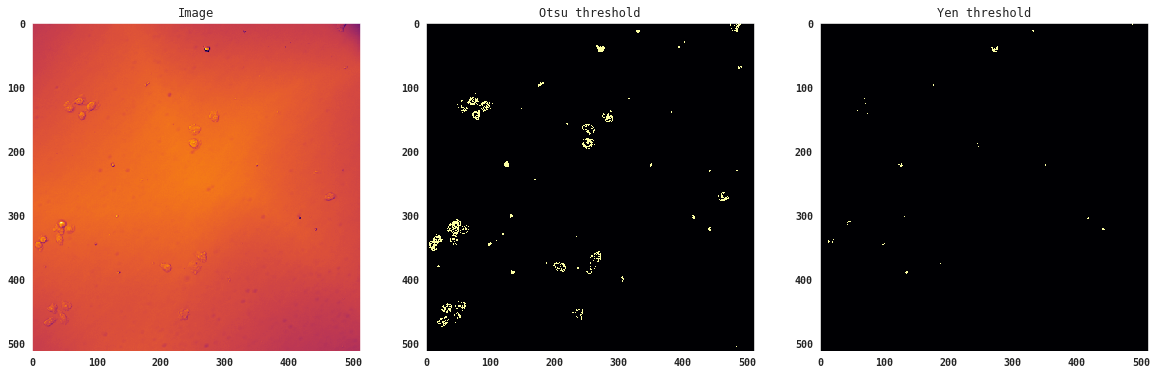

In [214]:
thresh_otsu = threshold_otsu(data_roberts)
thresh_yen = threshold_yen(data_roberts) 

mask_otsu = get_mask(data_roberts, thresh_otsu)
mask_yen = get_mask(data_roberts, thresh_yen)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(data[channel])
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, vmin=0, vmax=1)
ax[1].set_title('Otsu threshold')

ax[2].imshow(mask_yen, vmin=0, vmax=1)
ax[2].set_title('Yen threshold')